# DeepDreaming with TensorFlow

>[Loading the model graph](#loading)

>[Naive feature visualization](#naive)

>[Multiscale image generation](#multiscale)

>[Laplacian Pyramid Gradient Normalization](#laplacian)

>[Playing with feature visualzations](#playing)

>[DeepDream](#deepdream)



This notebook demonstrates a number of Convolutional Neural Network image generation techniques implemented with TensorFlow for fun and science:

- visualize individual feature channels and their combinations to explore the space of patterns learned by the neural network (see [GoogLeNet](http://storage.googleapis.com/deepdream/visualz/tensorflow_inception/index.html) and [VGG16](http://storage.googleapis.com/deepdream/visualz/vgg16/index.html) galleries)
- embed TensorBoard graph visualizations into Jupyter notebooks
- produce high-resolution images with tiled computation ([example](http://storage.googleapis.com/deepdream/pilatus_flowers.jpg))
- use Laplacian Pyramid Gradient Normalization to produce smooth and colorful visuals at low cost
- generate DeepDream-like images with TensorFlow (DogSlugs included)


The network under examination is the [GoogLeNet architecture](http://arxiv.org/abs/1409.4842), trained to classify images into one of 1000 categories of the [ImageNet](http://image-net.org/) dataset. It consists of a set of layers that apply a sequence of transformations to the input image. The parameters of these transformations were determined during the training process by a variant of gradient descent algorithm. The internal image representations may seem obscure, but it is possible to visualize and interpret them. In this notebook we are going to present a few tricks that allow to make these visualizations both efficient to generate and even beautiful. Impatient readers can start with exploring the full galleries of images generated by the method described here for [GoogLeNet](http://storage.googleapis.com/deepdream/visualz/tensorflow_inception/index.html) and [VGG16](http://storage.googleapis.com/deepdream/visualz/vgg16/index.html) architectures.

In [1]:
# boilerplate code
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

import tensorflow as tf
from tensorflow.contrib import image

<a id='loading'></a>
## Loading the model graph

The pretrained network can be downloaded [here](https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip). Unpack the `tensorflow_inception_graph.pb` file from the archive and set its path to `model_fn` variable. Alternatively you can uncomment and run the following cell to download the network:

In [2]:
#!wget https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip inception5h.zip

In [3]:
print(tf.__version__)

1.14.0


In [4]:
# model_fn = 'greebles_inv_train_argmax.pb' #works but not softmax
# model_fn = 'greebles_inv_train_softmax.pb' #im going to say this works!!
model_fn = 'cifar_softmax.pb'
# model_fn = 'frozen_resnet_v2_50.pb'
# creating TensorFlow session and loading the model from the model_fn file 
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
# t_input = tf.placeholder(np.float32, name='input') # define the input tensor
# t_input_1 = tf.placeholder(np.int64, name='input_1') # define the input tensor
t_input_1 = tf.constant([1], np.int64, name='input_1') # define the input tensor
# t_input_2 = tf.placeholder(np.float32, name='input_2') # define the input tensor
t_input_3 = tf.constant(False, name='input_3') # define the input tensor
imagenet_mean = 117.0
# imagenet_mean = 0.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
# tf.import_graph_def(graph_def, {'input/Placeholder':t_preprocessed})
# tf.import_graph_def(graph_def, {'input/map/TensorArrayStack/TensorArrayGatherV3':t_preprocessed}) #WORKS kind of, only for first conv2d
# tf.import_graph_def(graph_def, {'input/map/TensorArrayStack/TensorArrayGatherV3':t_preprocessed, 'input/Placeholder_3':t_input_3})
tf.import_graph_def(graph_def, {'input/map/TensorArrayStack/TensorArrayGatherV3':t_preprocessed, 'input/Placeholder_3':t_input_3, 'input/Placeholder_1':t_input_1})
# tf.import_graph_def(graph_def, {'input/Placeholder':t_preprocessed, 'input/Placeholder_1':t_input_1, 'input/Placeholder_2':t_input_2, 'input/Placeholder_3':t_input_3})

Instructions for updating:
Use tf.gfile.GFile.


In [5]:
# for op in graph.get_operations(): 
# #     t = op.type.lower()
# #     if t == 'maxpool' or t == 'relu' or t == 'conv2d':
# #         for input in op.inputs:
# #             print(input.name, input.dtype)
#     print(op.name, op.outputs)
names = [n.name for n in tf.get_default_graph().as_graph_def().node]
# names = [(n.name, n.attr['shape']) for n in tf.get_default_graph().as_graph_def().node]
# print(names[:-1])
for n in names:
    print(n)

input
input_1
input_3
sub/y
sub
ExpandDims/dim
ExpandDims
import/global_step
import/input/Placeholder
import/input/Placeholder_1
import/input/Placeholder_2
import/input/unstack
import/input/mul/y
import/input/mul
import/input/Placeholder_3
import/input/Pad/paddings
import/input/Pad
import/input/Shape
import/input/ones/Const
import/input/ones
import/input/Shape_1
import/input/zeros/Const
import/input/zeros
import/input/Neg
import/input/Neg_1
import/input/stack
import/input/rotate/Shape
import/input/rotate/strided_slice/stack
import/input/rotate/strided_slice/stack_1
import/input/rotate/strided_slice/stack_2
import/input/rotate/strided_slice
import/input/rotate/Cast
import/input/rotate/strided_slice_1/stack
import/input/rotate/strided_slice_1/stack_1
import/input/rotate/strided_slice_1/stack_2
import/input/rotate/strided_slice_1
import/input/rotate/Shape_1
import/input/rotate/strided_slice_2/stack
import/input/rotate/strided_slice_2/stack_1
import/input/rotate/strided_slice_2/stack_2
imp

To take a glimpse into the kinds of patterns that the network learned to recognize, we will try to generate images that maximize the sum of activations of particular channel of a particular convolutional layer of the neural network. The network we explore contains many convolutional layers, each of which outputs tens to hundreds of feature channels, so we have plenty of patterns to explore.

In [6]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))
#feature_nums

Number of layers 31
Total number of feature channels: 1136


In [7]:
def T(layer):
    '''Helper for getting layer output tensor'''
#     return graph.get_tensor_by_name("import/%s:0"%layer)
    return graph.get_tensor_by_name("%s:0"%layer)

In [8]:
layer=layers[4]
print(layer)
# layer = layer.split("/")[1]
print(layer)

import/unit_1_1/sub2/conv2/Conv2D
import/unit_1_1/sub2/conv2/Conv2D


In [9]:
T(layer)

<tf.Tensor 'import/unit_1_1/sub2/conv2/Conv2D:0' shape=(?, ?, ?, 16) dtype=float32>

In [10]:
for l, layer in enumerate(layers):
#     layer = layer.split("/")[1]
    num_channels = T(layer).shape[3]
    print(layer, num_channels)

import/input/init_conv/Conv2D 16
import/unit_1_0/sub1/conv1/Conv2D 16
import/unit_1_0/sub2/conv2/Conv2D 16
import/unit_1_1/sub1/conv1/Conv2D 16
import/unit_1_1/sub2/conv2/Conv2D 16
import/unit_1_2/sub1/conv1/Conv2D 16
import/unit_1_2/sub2/conv2/Conv2D 16
import/unit_1_3/sub1/conv1/Conv2D 16
import/unit_1_3/sub2/conv2/Conv2D 16
import/unit_1_4/sub1/conv1/Conv2D 16
import/unit_1_4/sub2/conv2/Conv2D 16
import/unit_2_0/sub1/conv1/Conv2D 32
import/unit_2_0/sub2/conv2/Conv2D 32
import/unit_2_1/sub1/conv1/Conv2D 32
import/unit_2_1/sub2/conv2/Conv2D 32
import/unit_2_2/sub1/conv1/Conv2D 32
import/unit_2_2/sub2/conv2/Conv2D 32
import/unit_2_3/sub1/conv1/Conv2D 32
import/unit_2_3/sub2/conv2/Conv2D 32
import/unit_2_4/sub1/conv1/Conv2D 32
import/unit_2_4/sub2/conv2/Conv2D 32
import/unit_3_0/sub1/conv1/Conv2D 64
import/unit_3_0/sub2/conv2/Conv2D 64
import/unit_3_1/sub1/conv1/Conv2D 64
import/unit_3_1/sub2/conv2/Conv2D 64
import/unit_3_2/sub1/conv1/Conv2D 64
import/unit_3_2/sub2/conv2/Conv2D 64
impor

<a id='naive'></a>
## Naive feature visualization

Let's start with a naive way of visualizing these. Image-space gradient ascent!

In [11]:
# Picking some internal layer. Note that we use outputs before applying the ReLU nonlinearity
# to have non-zero gradients for features with negative initial activations.
# layer = 'import/unit_3_4/sub2/conv2/Conv2D'
layer = 'import/unit_3_4/sub2/conv2/Conv2D:0'
# layer = 'import/unit_last/leaky_relu:0'
# layer = 'import/costs/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:1'
# layer = 'import/logit/xw_plus_b:0'
channel = 1 # picking some feature channel to visualize

# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0
# img_noise = np.random.uniform(size=(32,32,3)) + 100.0


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


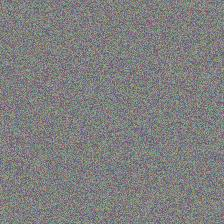

0 -22.88929 

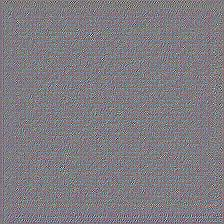

1 -21.69515 

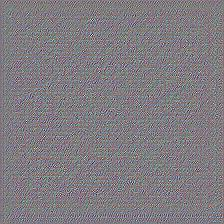

2 -19.414137 

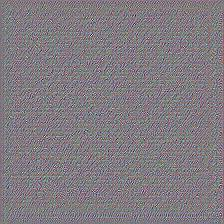

3 -17.533537 

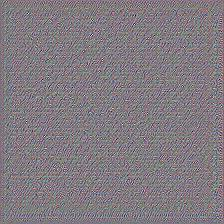

4 -15.805211 

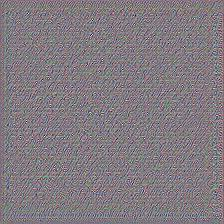

5 -14.086998 

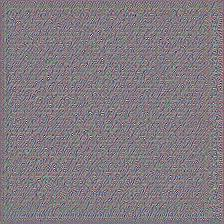

6 -12.567921 

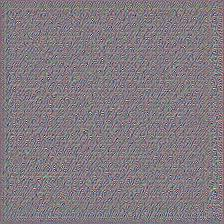

7 -11.398273 

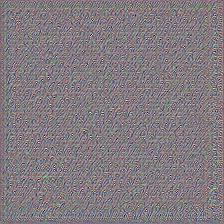

8 -10.367063 

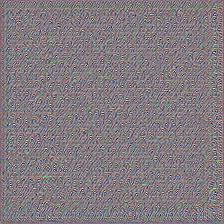

9 -9.481244 

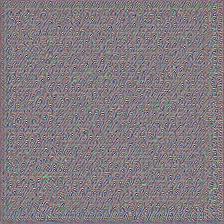

10 -8.651738 

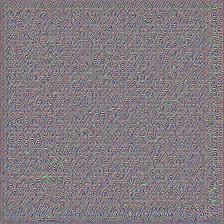

11 -7.865837 

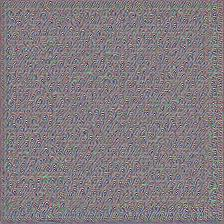

12 -7.1921735 

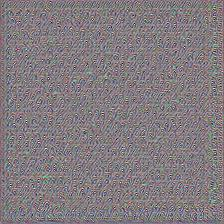

13 -6.4618125 

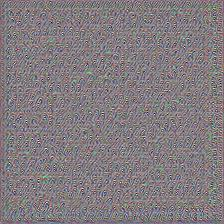

14 -5.7343383 

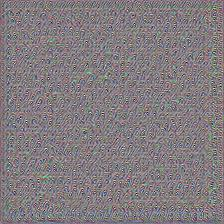

15 -5.1451426 

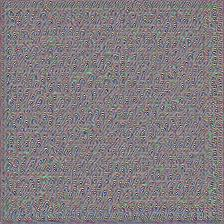

16 -4.4402966 

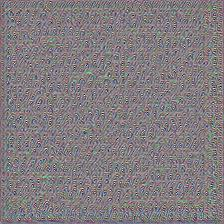

17 -3.8510842 

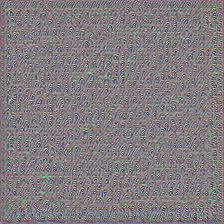

18 -3.1385803 

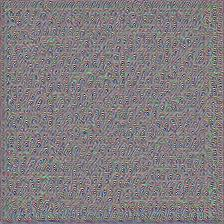

19 -2.4910982 

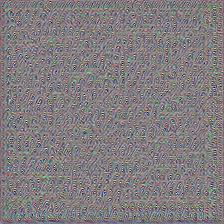

In [12]:

def showarray(a, fmt='jpeg'):
    '''create a jpeg file from an array a and visualize it'''
    # clip the values to be between 0 and 255
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5


def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    
    # t_obj: is the featuremap (or maps) where we want to mixamise the activities of the neurons e.g. T(layer)[:,:,:,channel]
    # img0: is the input image e.g. random noise or a cat
    # iter_n: number of iterations in the gradient ascent
    # step: step size of the gradient
    
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective (mean of the neuron activities in t_obj)
    t_grad = tf.gradients(t_score, t_input)[0] # calculate the gradient of the objective function!!!
    
    img = img0.copy()
    showarray(visstd(img)) # show the input image
    
    for i in range(iter_n): # for iter_n iterations keep updating the image
        g, score = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
        print(i, score, end = ' ') # show the current objective value
        showarray(visstd(img)) # show the actual image
    #clear_output()
    

# render_naive(T(layer)[:,:,:,channel]) # run the render_naive function and start halucinating!
actual_T = graph.get_tensor_by_name(layer)
# render_naive(actual_T[:,channel]) # run the render_naive function and start halucinating!
render_naive(actual_T[:,:,:,channel]) # run the render_naive function and start halucinating!

# print(T(layer).shape)
# t_obj = T(layer)[:,:,:,channel]
# print(t_obj)
# t_score = tf.reduce_mean(t_obj)
# print(t_score)
# t_grad = tf.gradients(t_score, t_input)[0]

<a id="multiscale"></a>
## Multiscale image generation

Looks like the network wants to show us something interesting! Let's help it. We are going to apply gradient ascent on multiple scales. Details formed on smaller scale will be upscaled and augmented with additional details on the next scale.

With multiscale image generation it may be tempting to set the number of octaves to some high value to produce wallpaper-sized images. Storing network activations and backprop values will quickly run out of GPU memory in this case. There is a simple trick to avoid this: split the image into smaller tiles and compute each tile gradient independently. Applying random shifts to the image before every iteration helps avoid tile seams and improves the overall image quality.

In [13]:
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)


def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
#     print("Tile Size:", sz)
    h, w = img.shape[:2] # size of the image
#     print("Height:{}, Width:{}".format(h, w))
    sx, sy = np.random.randint(sz, size=2) # random shift numbers generated
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0) #shift the whole image. np.roll = Roll array elements along a given axis
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz] # get the image patch (tile)
            g = sess.run(t_grad, {t_input:sub}) # calculate the gradient only in the image patch not in the whole image!
            grad[y:y+sz,x:x+sz] = g # put the whole gradient together from the tiled gradients g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0) # shift back

In [14]:
def render_multiscale(t_obj, img0=img_noise, iter_n=10, step=1.0, octave_n=3, octave_scale=1.5):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale # calculate new height and width (scale up by octave_scale)
            img = resize(img, np.int32(hw)) # rescale the image to the new size
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad) # calculate the gradient of the new image in each pixel using the calc_grad_tiled function
            # normalizing the gradient, so the same step size should work 
            g /= g.std()+1e-8         # for different layers and networks
            img += g*step # update the image with the gradient
            print('.', end = ' ')
            #clear_output()
            showarray(visstd(img))

# render_multiscale(T(layer)[:,:,:,channel])

<a id="laplacian"></a>
## Laplacian Pyramid Gradient Normalization

This looks better, but the resulting images mostly contain high frequencies. Can we improve it? One way is to add a smoothness prior into the optimization objective. This will effectively blur the image a little every iteration, suppressing the higher frequencies, so that the lower frequencies can catch up. This will require more iterations to produce a nice image. Why don't we just boost lower frequencies of the gradient instead? One way to achieve this is through the [Laplacian pyramid](https://en.wikipedia.org/wiki/Pyramid_%28image_processing%29#Laplacian_pyramid) decomposition. We call the resulting technique _Laplacian Pyramid Gradient Normalization_.

In [15]:
k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    img = tf.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels)
    return out[0,:,:,:]

# Showing the lap_normalize graph with TensorBoard
lap_graph = tf.Graph()
with lap_graph.as_default():
    lap_in = tf.placeholder(np.float32, name='lap_in')
    lap_out = lap_normalize(lap_in)


In [16]:
def render_lapnorm(t_obj, img0=img_noise, visfunc=visstd,
                   iter_n=10, step=1.0, octave_n=3, octave_scale=1.5, lap_n=4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))

    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            g = lap_norm_func(g)
            img += g*step
            print(i, end = ' ')
        clear_output()
        showarray(visfunc(img))
    return img

# render_lapnorm(T(layer)[:,:,:,channel])

# Custom

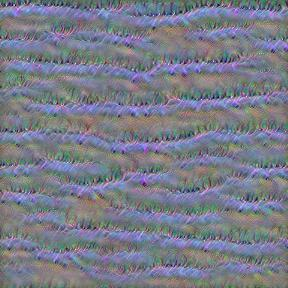

(288, 288, 3)


In [37]:
# np.random.seed(2018)
# tf.set_random_seed(2)
# img_noise = np.random.uniform(size=(224,224,3)) + 100.0
img_noise = np.random.uniform(size=(128,128,3)) + 100.0
# img_noise = np.random.uniform(size=(32,32,3)) + 100.0
#capas = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
capas = [op.name for op in graph.get_operations() if 'Softmax' in op.type and 'import/' in op.name]
for op in graph.get_operations():
    if 'import/' in op.name and 'oftmax' in op.type:
        print("Tensors: {} -> {}".format(op.type, op.name))
# capa = 'import/costs/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:1'
# capa = 'import/unit_1_0/sub1/conv1/Conv2D:0'

capa = 'import/unit_3_4/sub2/conv2/Conv2D:0'

# capa = 'import/unit_last/leaky_relu:0'
# capa = 'logit/xw_plus_b:0'
canal = 3
print(capas)
actual_T = graph.get_tensor_by_name(capa)
# print("Channels: ", actual_T.shape[1], '\n', actual_T,'\n')
# print(actual_T[:,canal], '\n')
print(actual_T)

# tf.gradients(tf.reduce_mean(actual_T), actual_T)[0]
# for l, layer in enumerate(capas):
#     layer = layer.split("/")[1]
#     num_channels = T(layer).shape[0]
#     print(layer, num_channels)
#     print(T(layer))
print("*"*20)
tests = []
# T("softmax2").shape[1]
# T(capa)
# render_lapnorm(T(capa)[:,:,:,canal], iter_n=10, step=1.0, octave_n=3)
# capa = 'import/unit_3_4/sub2/conv2/Conv2D'
# T(capa)
# render_lapnorm(T(capa)[:,:,:,canal], iter_n=10, step=1.0, octave_n=3)

# img = render_lapnorm(actual_T[:,canal], img0=img_noise, iter_n=30, step=0.0005, octave_n=3, octave_scale=1.5, lap_n=4) #kind of worked with small step size
# img = render_lapnorm(actual_T[:,canal], img0=img_noise, iter_n=300, step=1.0, octave_n=3, octave_scale=1.5, lap_n=4)
# img = render_lapnorm(actual_T[:,canal], img0=img_noise, iter_n=10, step=1.0, octave_n=3, octave_scale=1.5, lap_n=4)

# img = render_lapnorm(actual_T[:,:,:,canal], img0=img_noise, iter_n=30, step=200.0, octave_n=3, octave_scale=1.5, lap_n=4)
img = render_lapnorm(actual_T[:,:,:,canal], img0=img_noise, iter_n=30, step=1.0, octave_n=3, octave_scale=1.5, lap_n=4)
print(img.shape)

# num_images = 10
# num_images = 2
# for i in range(num_images):
# #     clear_output()
#     print(i)
# #     tests.append(render_lapnorm(T(capa)[:,canal], iter_n=10, step=1.0, octave_n=3))
#     tests.append(render_lapnorm(actual_T[:,canal], iter_n=30, step=1.0, octave_n=2))
# # showarray(visstd(img_noise))

10


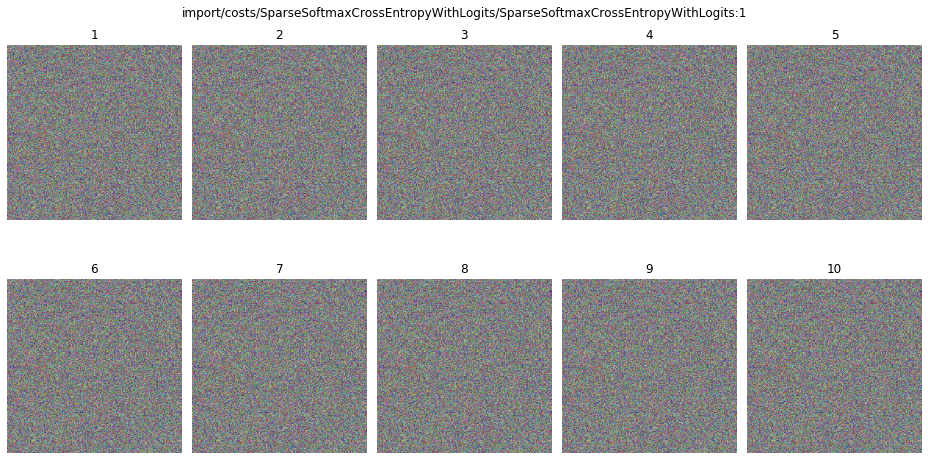

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_image(a, fmt='jpeg'):
    '''create a jpeg file from an array a and visualize it'''
    # clip the values to be between 0 and 255
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def showarray_no(a, fmt='jpeg'):
    '''create a jpeg file from an array a and visualize it'''
    # clip the values to be between 0 and 255
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
#     display(Image(data=f.getvalue()))
#     plt.figure()
#     plt.imshow(a)
    return a

# showarray(visstd(tests[-1]))
a = np.asarray(tests)
a = np.mean(a, axis=0)
# for im in tests:
#     showarray(visstd(im))

# print("Mean image:")
# showarray(visstd(a))

names = [i for i in range(num_images)]
size = (13, 7)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=size)
fig.subplots_adjust(hspace=0.15, wspace=.1)
fig.suptitle(capa)

for ax, im, name in zip(axes.flatten(), tests, names):
    ax.imshow(showarray_no(visstd(im)))
    ax.axis("off")
    ax.set(title=name+1)
fig.tight_layout()
# fig.savefig('visual1.png', dpi=300)

print(num_images)
#Average image
# plt.figure()
# plt.imshow(showarray(visstd(a)))
# plt.title("Mean image")
# show_image(visstd(a))

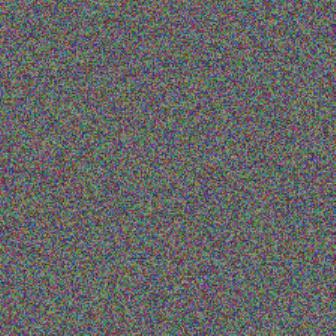

array([[[0.4318567 , 0.46574816, 0.19982307],
        [0.5066491 , 0.54166263, 0.25800073],
        [0.54672706, 0.45641968, 0.39980552],
        ...,
        [0.607336  , 0.5368151 , 0.44549033],
        [0.40949306, 0.5934854 , 0.47807267],
        [0.31057534, 0.6218224 , 0.49436197]],

       [[0.39828318, 0.5850471 , 0.36009777],
        [0.5353863 , 0.5334301 , 0.44084856],
        [0.59127486, 0.45094752, 0.53164595],
        ...,
        [0.33934996, 0.5840111 , 0.3159839 ],
        [0.4420492 , 0.45790836, 0.42194846],
        [0.4934007 , 0.39484578, 0.47493824]],

       [[0.37069422, 0.4841246 , 0.4835897 ],
        [0.5415766 , 0.41183454, 0.48343635],
        [0.5629752 , 0.38276815, 0.48149136],
        ...,
        [0.19895533, 0.52663755, 0.30206972],
        [0.41078722, 0.3757325 , 0.42205694],
        [0.51670694, 0.3002781 , 0.4820412 ]],

       ...,

       [[0.19416764, 0.4319502 , 0.36595145],
        [0.33041424, 0.47517765, 0.3685959 ],
        [0.41824177, 0

In [74]:
aaaa = np.asarray(tests)
aaaa = np.mean(aaaa, axis=0)
# show_image((aaaa-aaaa.mean())/max(aaaa.std(), 1e-4)*0.1 + 0.5)
temppp = (aaaa-aaaa.mean())/max(aaaa.std(), 1e-4)*0.1 + 0.4
# temppp = (aaaa-aaaa.min())/(aaaa.max() - aaaa.min())
show_image(temppp)
temppp
# layer = 'import/InceptionV3/Predictions/Softmax'
# channel = 1 # picking some feature channel to visualize
# showarray(visstd(render_lapnorm(T(layer)[:,channel], iter_n=20, step=0.5, octave_n=3)))

<a id="playing"></a>
## Playing with feature visualizations

We got a nice smooth image using only 10 iterations per octave. In case of running on GPU this takes just a few seconds. Let's try to visualize another channel from the same layer. The network can generate wide diversity of patterns.

In [ ]:
print(layer)
print(channel)

In [ ]:
render_lapnorm(T(layer)[:,:,:,65])

Lower layers produce features of lower complexity.

In [ ]:
render_lapnorm(T('mixed3b_1x1_pre_relu')[:,:,:,121])

There are many interesting things one may try. For example, optimizing a linear combination of features often gives a "mixture" pattern.

In [ ]:
render_lapnorm(T(layer)[:,:,:,65]+T(layer)[:,:,:,139], octave_n=4)

<a id="deepdream"></a>
## DeepDream

Now let's reproduce the [DeepDream algorithm](https://github.com/google/deepdream/blob/master/dream.ipynb) with TensorFlow. 


In [ ]:
def render_deepdream(t_obj, img0=img_noise,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image into a number of octaves getting smaller and smaller images
    img = img0
    octaves = []
    for i in range(octave_n-1):
        hw = img.shape[:2] #image height and width
        lo = resize(img, np.int32(np.float32(hw)/octave_scale)) #low frequency parts (smaller image)
        hi = img-resize(lo, hw) #high frequency parts (details)
        img = lo # next iteration rescale this one
        octaves.append(hi) # add the details to octaves
    
    # generate details octave by octave from samll image to large
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            print('.',end = ' ')
            #clear_output()
            showarray(img/255.0)

Let's load some image and populate it with DogSlugs (in case you've missed them).

In [ ]:
img0 = PIL.Image.open('pilatus800.jpg')
img0 = np.float32(img0)
showarray(img0/255.0)

In [ ]:
render_deepdream(tf.square(T('mixed4c')), img0)

Note that results can differ from the [Caffe](https://github.com/BVLC/caffe)'s implementation, as we are using an independently trained network. Still, the network seems to like dogs and animal-like features due to the nature of the ImageNet dataset.

Using an arbitrary optimization objective still works:

In [ ]:
render_deepdream(T(layer)[:,:,:,139], img0)

Don't hesitate to use higher resolution inputs (also increase the number of octaves)! Here is an [example](http://storage.googleapis.com/deepdream/pilatus_flowers.jpg) of running the flower dream over the bigger image.

We hope that the visualization tricks described here may be helpful for analyzing representations learned by neural networks or find their use in various artistic applications.